# Analysis of MechDetect Accuracy

The 0.5 error rate and all error rate plots for clean and dirty data are created here.

In [35]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

from matplotlib import font_manager as fm
from pathlib import Path
from scipy.stats import t, sem

In [36]:
# Function definitions & Mics code
def read_in_data_cube(base_path: str = "./auc_roc_scores/data", filename: str = "auc_roc_tensors_dict.npz") -> dict[str:np.ndarray]:
    """Read in the numpy array given a base path, the dataset_id, and the error_rate."""
    path = os.path.join(base_path, filename)
    return np.load(path, allow_pickle=True)


def decide_error_mech(case_1: np.ndarray, case_2: np.ndarray, case_3: np.ndarray, alpha: float = 0.05) -> str:
    """Predict the error mechanism using the mech detect as described below.
    
    Description:
        - Two step test that does the following sub-tests:
            1. Test complete scores vs. shuffled scores using H_0: complete <= shuffled, H_A: complete > shuffled
            2. Test complete scores vs. missing scores using H_0: complete <= missing, H_A: complete > missing
        - The resulting decision is decided as follows:
            1. If we reject H_0 -> step 2. If we fail to reject H_0 -> ECAR
            2*. If we reject H_0 -> ENAR. If we fail to reject H_0 -> EAR
            * Step 2 is only performed if necessary
    
    Inputs:
        - case_1 (np.ndarray): The performance of a model trained to predict the error mask of a given column using all input data. (aka Complete Task)
        - case_2 (np.ndarray): The performance of a model trained to predict the randomly permuted error mask of a given column using all input data. (aka Shuffled Task)
        - case_3 (np.ndarray): The performance of a model trained to predict the error mask of a given column using all data except that column. (aka Missing Task)
        - alpha (float, optional): The significance level of the test. Defaults to 0.05.
    
    Return:
        - A string, one of: "ECAR", "EAR", "ENAR"        
    """
    
    result: str

    # Sub-Test 1 - H_0: case_1 <= case_2, H_A: case_1 > case_2
    w_stat_1, p_value_1 = stats.mannwhitneyu(case_1, case_2, alternative='greater')
    # Sub-Test 2 - H_0: case_1 <= case_3, H_A: case_1 > case_3
    w_stat_2, p_value_2 = stats.mannwhitneyu(case_1, case_3, alternative='greater')
    if p_value_1 < alpha/2:  # Reject H_0 - evidence against ECAR
        if p_value_2 < alpha/2:  # Reject H_0 - evidence against ECAR and EAR
            result = "ENAR"
        else:  # Fail to reject H_0 - no evidence against EAR
            result = "EAR"

    else:  # Fail to reject H_0 - no evidence against ECAR
        result = "ECAR"

    return result


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def setup_libertinus_fonts(font_dir="fonts"):
    font_dir = Path(font_dir)

    # Paths to font files you copied into 'fonts/'
    serif = font_dir / "LibertinusSerif-Regular.otf"
    italic = font_dir / "LibertinusSerif-Italic.otf"
    math = font_dir / "LibertinusMath-Regular.otf"
    sans = font_dir / "LibertinusSans-Regular.otf"  # optional

    # Register fonts
    for font_path in [serif, italic, math, sans]:
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
        else:
            print(f"Warning: {font_path} not found!")

    # Get the font name from the serif regular font file metadata
    font_name = fm.FontProperties(fname=str(serif)).get_name()

    # Update matplotlib rcParams globally
    mpl.rcParams.update({
        "font.family": font_name,
        "mathtext.fontset": "custom",
        "mathtext.rm": font_name,
        "mathtext.it": f"{font_name}:italic",
        "axes.labelsize": 9,
        "font.size": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    })



# Misc plotting code
setup_libertinus_fonts()
missingness_mechanisms_for_plotting = ["MCAR", "MAR", "MNAR"]  # Ordering is important!

In [37]:
# Read in data_cube
data_dict = read_in_data_cube()
dataset_ids = data_dict.files
dataset_ids

['1046',
 '1049',
 '1050',
 '1063',
 '1067',
 '1068',
 '1461',
 '1464',
 '1480',
 '1494',
 '151',
 '1510',
 '23',
 '23517',
 '251',
 '31',
 '310',
 '37',
 '40701',
 '40975',
 '40994',
 '4135',
 '42493',
 '44',
 '44025',
 '44026',
 '44054',
 '44055',
 '44056',
 '44059',
 '44061',
 '44062',
 '44063',
 '44064',
 '44066',
 '44089',
 '44090',
 '44091',
 '44120',
 '44122',
 '44123',
 '44124',
 '44125',
 '44126',
 '44127',
 '44130',
 '44131',
 '44132',
 '44133',
 '44134',
 '44136',
 '44137',
 '44138',
 '44139',
 '44140',
 '44141',
 '44142',
 '44144',
 '44145',
 '44147',
 '44148',
 '44156',
 '44157',
 '44158',
 '44160',
 '44162',
 '44956',
 '44957',
 '44958',
 '44959',
 '44960',
 '44962',
 '44963',
 '44964',
 '44966',
 '44967',
 '44969',
 '44970',
 '44971',
 '44972',
 '44974',
 '44976',
 '44977',
 '44978',
 '44979',
 '44980',
 '44981',
 '44983',
 '44984',
 '44987',
 '44989',
 '44990',
 '44993',
 '44994',
 '45012',
 '4534',
 '45402',
 '54',
 '6',
 '725',
 '823']

In [38]:
# Do the tests, accumulate results, write the cube!
processed_data = {}


for dataset_id in data_dict.files:
    tensor = data_dict[dataset_id]  # Shape (5, 3, n_cols, 2, 4, 10)
    
    # Create a new array to hold strings, same shape but last two dims flattened to one string
    result = np.empty(tensor.shape[:4], dtype=object)  # (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(tensor.shape[0]):  # Error rate
        for j in range(tensor.shape[1]):  # Error mechanism
            for k in range(tensor.shape[2]):  # Column
                for l in range(tensor.shape[3]):  # Clean/Dirty
                        one_instance = tensor[i,j,k,l]

                        # Perform tests, save results    
                        result[i,j,k,l] = decide_error_mech(one_instance[0], one_instance[1], one_instance[2])

    processed_data[dataset_id] = result
    
#  np.savez_compressed('../data/test_results_datacube.npz', **processed_data)  # Checkpoint'd

In [39]:
# Sanity check - 17 columns in dataset 6

assert processed_data['6'].shape == (5, 3, 17, 2)

In [40]:
# Analysis setup
error_mechanisms = ["ECAR", "EAR", "ENAR"]  # Ordering is important!
error_rates = ["0.1", "0.25", "0.5", "0.75", "0.9"]  # Ordering is important!

CLEAN = 0
DIRTY = 1

### Test Hit/Miss


In [41]:
boolean_tensors = {}

for dataset_id in data_dict.files:
    tensor = processed_data[dataset_id]  # Shape (5, 3, n_cols, 2, 4, 10)
    
    # Create a new array to hold strings, same shape but last two dims flattened to one string
    result = np.empty(tensor.shape[:4], dtype=object)  # (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(tensor.shape[0]):  # Error rate
        for j in range(tensor.shape[1]):  # Error mechanism
            for k in range(tensor.shape[2]):  # Column
                for l in range(tensor.shape[3]):  # Clean/Dirty
                    
                    if tensor[i,j,k,l] == error_mechanisms[j]:
                        result[i,j,k,l] = True
                    else:
                        result[i,j,k,l] = False
                    
    boolean_tensors[dataset_id] = result

#  np.savez_compressed('./data/test_results_datacube_boolean.npz', **boolean_tensors)  # Checkpoint'd

### Graphical analysis - Clean

In [42]:
# Compile accuracies
clean_results = np.empty((5, 3, len(data_dict.files), 2))  # (5, 3, n_datasets, 2)

# Iterate over all datasets
for dataset_index, dataset_id in enumerate(data_dict.files):
    one_cube = boolean_tensors[dataset_id]  # Shape (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(one_cube.shape[0]):  # Error rate
        for j in range(one_cube.shape[1]):  # Error mechanism
            md_slice = one_cube[i,j,:,CLEAN]
            
            md_accuracy = np.mean(md_slice)
            
            clean_results[i, j, dataset_index] = md_accuracy

Clean Data All Error Rate Boxplots

In [43]:
clean_results.shape

(5, 3, 101, 2)

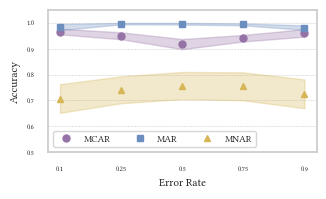

In [44]:
sns.set_theme(style="whitegrid", font_scale=1.0)
setup_libertinus_fonts()
# Custom colors and markers for each mechanism
mechanism_labels = ["MCAR", "MAR", "MNAR"]  # Match order to clean_results axis
colors = {
    "MCAR": "#9673A6",
    "MAR": "#6C8EBF",
    "MNAR": "#D6B656"
}
markers = {
    "MCAR": 'o',
    "MAR": 's',
    "MNAR": '^'
}

fig, ax = plt.subplots(figsize=set_size(241.14749, fraction=1.0))

# Plot each mechanism separately
for j, mech in enumerate(mechanism_labels):
    mean_accuracies = []
    bars = []

    for i in range(5):  # over error rates
        data = clean_results[i, j, :, 1]
        mean_accuracies.append(np.mean(data))
        n = len(data)
        ci95 = sem(data) * t.ppf(0.975, df=n-1) # bars indicate 95% confidence interval
        bars.append(ci95)
    
    ax.errorbar(
        error_rates,
        mean_accuracies,
        #yerr=bars,
        label=mech,
        fmt=markers[mech],
        capsize=3,
        color=colors[mech],
        markersize=5,
        linestyle='',
        elinewidth=.5
    )
    
    lower_bound = np.array(mean_accuracies) - np.array(bars)
    upper_bound = np.array(mean_accuracies) + np.array(bars)
    
    ax.fill_between(
        error_rates,
        lower_bound,
        upper_bound,
        color=colors[mech],
        alpha=0.3
    )

# Formatting
ax.set_xlabel("Error Rate", fontsize=8)
ax.set_ylabel("Accuracy", fontsize=8)
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=5)

ax.set_ylim(0.5, 1.05)
ax.set_xticks(error_rates)
ax.legend(title="", fontsize=7, title_fontsize=8, ncol=3)
ax.grid(axis='y', linestyle='--', linewidth=0.4)
ax.grid(axis='x', visible=False)

plt.tight_layout()
fig.savefig("../plots/2025-08-03-accuracy_over_error_fraction.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Graphical Analysis - Dirty

In [45]:
# Compile accuracies
dirty_results = np.empty((5, 3, len(data_dict.files), 2))  # (5, 3, n_datasets, 2)

# Iterate over all datasets
for dataset_index, dataset_id in enumerate(data_dict.files):
    one_cube = boolean_tensors[dataset_id]  # Shape (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(one_cube.shape[0]):  # Error rate
        for j in range(one_cube.shape[1]):  # Error mechanism
            md_slice = one_cube[i,j,:,DIRTY]
            
            md_accuracy = np.mean(md_slice)
            
            dirty_results[i, j, dataset_index] = md_accuracy

Dirty Data All Error Rate Boxplots

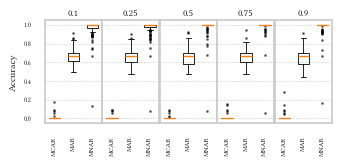

Accuracy on dirty data: 0.5438


In [46]:
# Set Seaborn style
sns.set_theme(style="whitegrid", font_scale=1.0)
setup_libertinus_fonts()
flierprops = dict(marker='o', markersize=1, markerfacecolor='black', linestyle='none', alpha=0.5)
median_color = '#ff7f0e'

# Single-column LaTeX figure size
fig, axes = plt.subplots(ncols=5, figsize=set_size(241.14749, fraction=1.0), sharey=True)

accuracy_dirty_data = []

for i, ax in enumerate(axes):
    box_data = [dirty_results[i, j, :, 1] for j in range(3)]
    accuracy_dirty_data.extend(box_data)

    positions = np.arange(1, len(box_data) + 1)
    ax.boxplot(
        box_data,
        positions=positions,
        flierprops=flierprops,
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor='none', color='black', linewidth=0.6),
        whiskerprops=dict(color='black', linewidth=0.6),
        capprops=dict(color='black', linewidth=0.6),
        medianprops=dict(color=median_color, linewidth=1.0),
    )

    ax.set_title(error_rates[i], fontsize=7, pad=3)
    ax.set_xticks(positions)
    ax.set_xticklabels(
        missingness_mechanisms_for_plotting,
        rotation=90,
        ha='center',
        fontsize=5
    )
    ax.tick_params(axis='y', labelsize=5)
    ax.grid(axis='y', linestyle='--', linewidth=0.4)
    ax.grid(axis='x', visible=False)

axes[0].set_ylabel("Accuracy", fontsize=7)

# Tighter layout tuning (same as clean version)
plt.subplots_adjust(
    left=0.12,
    right=0.98,
    bottom=0.38,
    top=0.88,
    wspace=0.01
)

fig.savefig("../plots/mechdetect_accuracy_dirty_boxplots.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

print(f"Accuracy on dirty data: {np.array(accuracy_dirty_data).mean():.4f}")

## Clean Data Error Rate 0.5

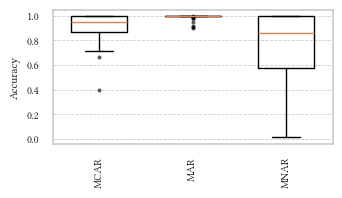

Avg. accuracy on with 0.5 error fraction: 89.04%
Median accuracy for MCAR: 0.9474
Median accuracy for MAR: 1.0000
Median accuracy for MNAR: 0.8571


In [48]:
# Match seaborn style
sns.set_theme(style="whitegrid")
setup_libertinus_fonts()
flierprops = dict(marker='o', markersize=2, markerfacecolor='black', linestyle='none', alpha=0.5)

error_index = 2  # Error rate = 0.5

# Prepare boxplot data
box_data_clean = [clean_results[error_index, j, :, 1] for j in range(3)]

fig, ax = plt.subplots(figsize=set_size(241.14749), sharey=True)

positions = np.arange(1, len(box_data_clean) + 1)
ax.boxplot(box_data_clean, positions=positions, flierprops=flierprops, widths=0.6)
ax.set_xticklabels(
    missingness_mechanisms_for_plotting,
    rotation=90,
    ha='center',
    fontsize=8
)
ax.set_ylabel("Accuracy", fontsize=8, x=-0.12)
ax.grid(axis='y', linestyle='--', linewidth=0.6)
ax.grid(axis='x', visible=False)

# Shrink y-labels
ax.tick_params(axis='y', labelsize=8)

# Adjust layout
plt.subplots_adjust(
    left=0.14,   # Reduce left margin
    right=0.98,  # Reduce right margin
    bottom=0.25, # Reduce bottom (x-tick label spacing)
    top=0.9,     # Leave a bit of space if there's a suptitle
    wspace=0.05   # Reduce inter-subplot horizontal space
)

# Save combined figure
fig.savefig("../plots/2025-08-03-accuracy_clean_point5.pdf", format="pdf")
plt.show()
print(f"Avg. accuracy on with 0.5 error fraction: {np.mean(box_data_clean)*100:.2f}%")
medians = [np.median(data) for data in box_data_clean]
for label, median in zip(missingness_mechanisms_for_plotting, medians):
    print(f"Median accuracy for {label}: {median:.4f}")